<a href="https://colab.research.google.com/github/agustinsilva447/QMARL/blob/main/paper_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from math import sqrt

In [19]:
def int_to_binary(n,m):
    if n == 0:
        return "0" * m
    binary1 = ""
    while n > 0:
        binary1 = str(n % 2) + binary1
        n = n // 2
    binary2 = "0" * (m - len(binary1)) + binary1
    return binary2
    
def rX_numpy(phi):
  rx = np.matrix([[    np.cos(phi/2), -1j*np.sin(phi/2)],
                  [-1j*np.sin(phi/2),     np.cos(phi/2)]])
  return rx

def rY_numpy(phi):
  ry = np.matrix([[np.cos(phi/2), -1*np.sin(phi/2)],
                  [np.sin(phi/2),    np.cos(phi/2)]])
  return ry

def depolarization(lamda):
  I = np.matrix([[1,  0],
                 [0,  1]])
  X = np.matrix([[0,  1],
                 [1,  0]])
  Y = np.matrix([[0, -1j],
                 [1j, 0]])
  Z = np.matrix([[1,  0],
                 [0, -1]])
  pauli_gates = [I, X, Y, Z]
  index = np.random.choice([0, 1, 2, 3], p = [1-lamda, lamda/3, lamda/3, lamda/3])
  return pauli_gates[index]

def final_strategy(rx_1, ry_2, rx_3, depo = 1):
  return depo * rx_3 * ry_2 * rx_1

In [54]:
def minority_matrix(prob):
  n = int(np.log2(len(prob)))
  mm = np.zeros([2**n,n])
  for i in range(n):
    mm[2**i][n-i-1] = 10 * n
  payoff = prob.transpose() * mm
  return payoff.tolist()[0]

def prisoners_2players(prob):
  n = int(np.log2(len(prob)))
  mm = np.zeros([2**n,n])
  mm[0] = [10, 10]
  mm[1] = [30,  0]
  mm[2] = [ 0, 30]
  mm[3] = [20, 20]
  payoff = prob.transpose() * mm
  return payoff.tolist()[0]


In [55]:
def Numpy_QGT_Nplayers(tipo, J_init, J_dg, lamda = 0):
    n_p = len(tipo)
    for i in range(n_p):
      
      if lamda == 0:
        players_gate = final_strategy(rX_numpy(tipo[i][0]), rY_numpy(tipo[i][1]), rX_numpy(tipo[i][2]))
      else:
        players_gate = final_strategy(rX_numpy(tipo[i][0]), rY_numpy(tipo[i][1]), rX_numpy(tipo[i][2]), depolarization(lamda))
      
      if i==0:
        strategies_gate = players_gate
      else:
        strategies_gate = np.kron(strategies_gate, players_gate)

    outputstate = J_dg * strategies_gate * J_init
    prob = np.power(np.abs(outputstate),2)
    #outp = [int_to_binary(i,n_p) for i in range(2**n_p)]
    #output = np.random.choice(outp, p=np.asarray(prob).reshape(-1))
    return prob

def matrix_reward(rotat, J_init, J_dg, a_type):  
  prob = Numpy_QGT_Nplayers(rotat, J_init, J_dg, a_type[1])
  reward_g = prisoners_2players(prob)
  return reward_g

def gradient_rotat(rew,r,j,k,e,a,J_init,J_dg):
  """
  r1 = copy.deepcopy(r)
  r1[j][k] -= e
  rew1 = matrix_reward(r1,J_init,J_dg,a)
  """
  r2 = copy.deepcopy(r)
  r2[j][k] += e  
  rew2 = matrix_reward(r2,J_init,J_dg,a)
  g_new = (rew2[j]-rew[j])/(2*e)
  return g_new

def gini_coefficient(list1):
    tot_rewards = [np.sum(i) for i in list1]
    n = len(tot_rewards)
    tot_rewards.append(0)
    sor_rewards = np.cumsum(np.sort(tot_rewards))
    are_rewards = 0
    for i in range(n):
        are_rewards += sor_rewards[i] + sor_rewards[i+1]
    are_rewards /= 2*n

    max_rewards = sor_rewards[-1] / 2
    gini_coef = (are_rewards) / (max_rewards)
    return gini_coef  

In [63]:
n       = 2
max_it  = 100000
q_noise = [0.000]
q_text  = ["0_000"]
gamman  = [np.pi/2]
#gamman  = [0]
alpha1n = [0.01]
alpha2n = [1e-8]
beta1n  = [0.9]
beta2n  = [0.99]
epsilnn = [1e-8]

In [64]:
for ii,q in enumerate(q_noise):
  total_fair = []
  total_rewr = []
  for gamma in gamman:
    init_mat = np.matrix([[1] if i==0 else [0] for i in range(2**n)])
    I_f = np.array(np.eye(2**n))
    X_f = np.array(np.flip(np.eye(2**n),0))
    J = np.matrix(np.cos(gamma/2) * I_f + 1j * np.sin(gamma/2) * X_f)
    J_dg = J.H
    J_init = J * init_mat
    for alpha1 in alpha1n:
      for alpha2 in alpha2n:
        for beta1 in beta1n:
          for beta2 in beta2n:
            for epsilon in epsilnn:
              print("N = {}. Quantum Noise = {}. A1 = {}. A2 = {}. B1 = {}. B2 = {}.".format(n, q, alpha1, alpha2, beta1, beta2))
              a_type = ['q', 0]
              b_type = ['q', q]
              rotat = [[np.pi * np.random.rand(), np.pi * np.random.rand(), np.pi * np.random.rand()] for i in range(n)]
              m = [[0.0,0.0,0.0] for i in range(n)]
              v = [[0.0,0.0,0.0] for i in range(n)]
              feedback   = [[] for i in range(n)]
              fairness   = []

              for t in trange(max_it):
                reward = matrix_reward(rotat, J_init, J_dg, a_type)
                aux = copy.deepcopy(rotat)
                for i in range(n):
                  feedback[i].append(reward[i])      
                  for j in range(3):
                    grad = gradient_rotat(reward,aux,i,j,epsilon,b_type,J_init,J_dg)
                    m[i][j] = beta1 * m[i][j] + (1.0 - beta1) * grad
                    v[i][j] = beta2 * v[i][j] + (1.0 - beta2) * grad**2
                    mhat = m[i][j] / (1.0 - beta1**(t+1))
                    vhat = v[i][j] / (1.0 - beta2**(t+1))      
                    rotat[i][j] = rotat[i][j] + alpha1 * mhat / (sqrt(vhat) + alpha2)
                    while (rotat[i][j]<0) or (2*np.pi<=rotat[i][j]):
                      if (rotat[i][j]<0):
                        rotat[i][j] += 2*np.pi
                      if (2*np.pi<=rotat[i][j]):
                        rotat[i][j] -= 2*np.pi
                gini = gini_coefficient(feedback)
                fairness.append(gini)

              avgr = np.mean(feedback)
              gini = gini_coefficient(feedback)
              print("AVGR = {:.6f}. GINI = {:.6f}.".format(avgr, gini))

N = 2. Quantum Noise = 0.0. A1 = 0.01. A2 = 1e-08. B1 = 0.9. B2 = 0.99.


100%|██████████| 100000/100000 [22:28<00:00, 74.17it/s]

AVGR = 19.221830. GINI = 0.988535.


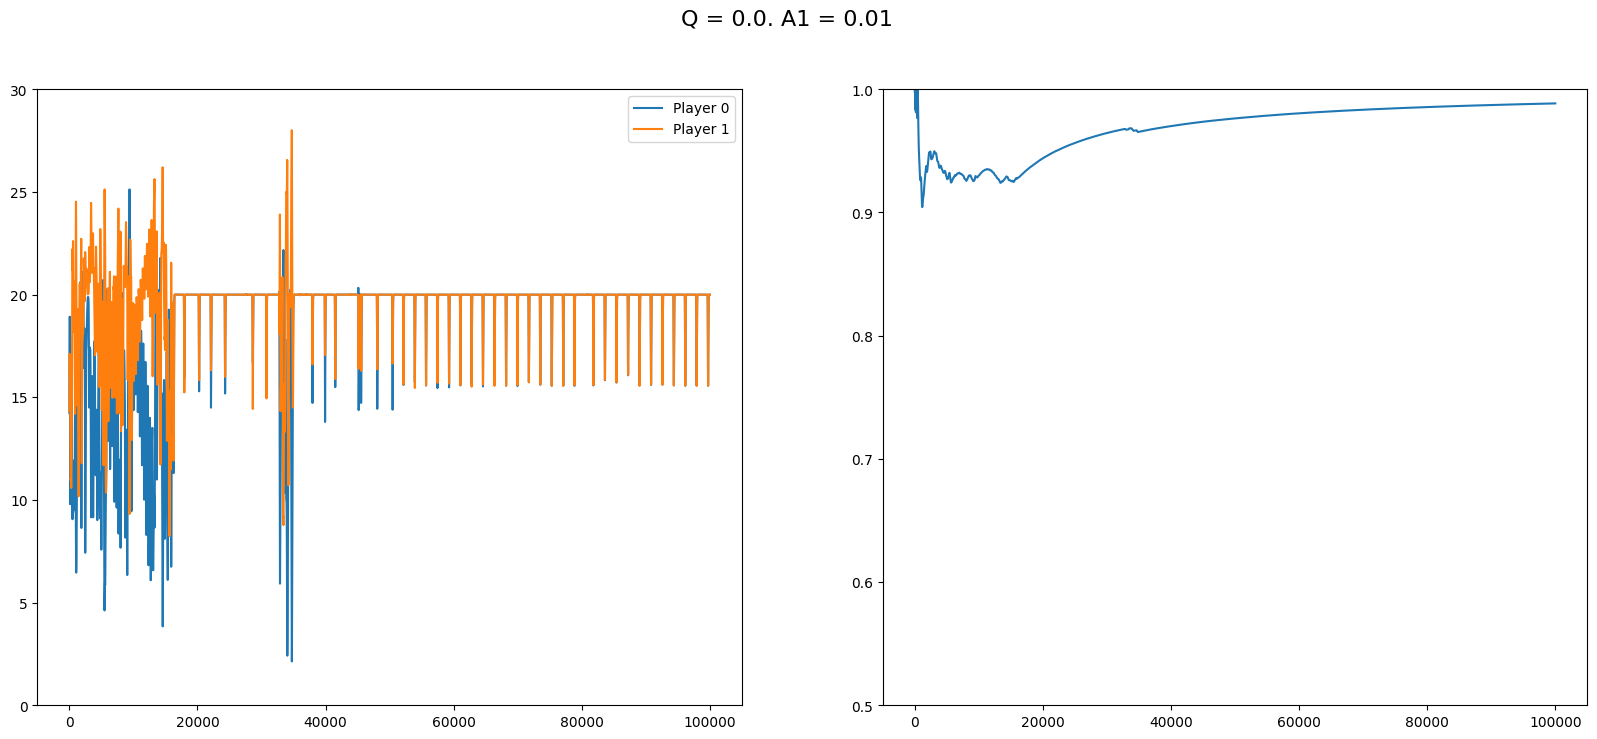

In [67]:
fig0, axs = plt.subplots(1,2,figsize=(20,8))
fig0.suptitle("Q = {}. A1 = {}".format(q, alpha1), fontsize=16)
for i in range(n):
  axs[0].plot(feedback[i], label="Player {}".format(i))
axs[1].plot(fairness)
#axs[0].set_ylim(0, 10 * n)
axs[0].set_ylim(0, 30)
axs[1].set_ylim(1/n, 1)
axs[0].legend()
plt.show()